In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import normalize
from sklearn.preprocessing import PolynomialFeatures


In [2]:
# import datasets into dataframes, drop unnecessary columns
game_df = pd.read_csv("game_data.csv", sep=',')
player_df = pd.read_csv("player_data.csv", sep=',')
train_df = pd.read_csv("training_set.csv", sep=',')
test_df = pd.read_csv("test_set.csv", sep=',')
team_df = pd.read_csv("team_data.csv", sep=',')

game_df = game_df[['Season', 'Game_ID', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm', 'Losses_Entering_Gm']]
player_df = player_df[['Season', 'Game_ID', 'Game_Date', 'Team', 'Person_ID', 'Name', 'ASG_Team', 'Active_Status']]


In [3]:
print list(game_df)
print list(player_df)
print list(train_df)
print list(test_df)
print list(team_df)

print test_df[0:3]
print team_df[0:3] # my outside data

['Season', 'Game_ID', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm', 'Losses_Entering_Gm']
['Season', 'Game_ID', 'Game_Date', 'Team', 'Person_ID', 'Name', 'ASG_Team', 'Active_Status']
['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team', 'Country', 'Rounded Viewers']
['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team', 'Total_Viewers']
['Team', 'Market_Size', 'Championships', 'Playoffs', 'Twitter']
    Season   Game_ID   Game_Date Away_Team Home_Team  Total_Viewers
0  2016-17  21600010  10/26/2016       DEN       NOP            NaN
1  2016-17  21600023  10/28/2016       HOU       DAL            NaN
2  2016-17  21600027  10/29/2016       BOS       CHA            NaN
  Team  Market_Size  Championships  Playoffs  Twitter
0  MIL         2255              1         7    0.462
1  GSW         6750              4         5    1.688
2  MIN         4667              0         4    0.458


In [4]:
# major rivalries aquired by Wikipedia
rivalry = [('CLE', 'GSW'), ('BOS', 'LAL'), ('LAL', 'DET'), ('PHI', 'BOS'), ('BOS', 'NYK'), 
           ('NYK', 'BKN'), ('CHI', 'DET'), ('CHI', 'CLE'), ('CHI', 'MIA'), ('CHI', 'NYK'), 
           ('BOS', 'DET'), ('MIA', 'NYK'), ('NYK', 'IND'), ('LAL', 'LAC'), ('DAL', 'HOU'),
           ('HOU', 'SAS'), ('UTA', 'HOU'), ('LAL', 'SAS'), ('SAS', 'PHX')]

# US national holidays
holiday = ['9/3/2016', '10/8/2016', '11/12/2016', '11/22/2016', 
           '11/23/2016', '12/25/2016', '1/1/2017', '1/15/2017', '2/19/2017', 
           '4/16/2017', '5/13/2017', '5/28/2017', '6/17/2017', '7/4/2017', '9/3/2017', 
           '10/8/2017', '11/12/2017', '11/22/2017', '11/23/2017', 
           '12/25/2017', '1/1/2018', '1/15/2018', '2/19/2018', '4/16/2018', 
           '5/13/2018', '5/28/2018','6/17/2018', '7/4/2018']

# NBA regular season first week
first = ['10/25/2016', '10/26/2016', '10/27/2016', '10/28/2016', '10/29/2016',
         '10/30/2016', '10/31/2016', '10/17/2017', '10/18/2017', '10/19/2017',
         '10/20/2017', '10/21/2017', '10/22/2017', '10/23/2017',]

# NBA regular season last two days
last = ['4/11/2017', '4/12/2017', '4/10/2017', '4/11/2018'] 


In [5]:
# create training/test set for 2016 model, we add features to this later
model_train_X = train_df[['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team']].drop_duplicates().reset_index(drop=True) 
model_output_X = test_df[['Season', 'Game_ID', 'Game_Date', 'Away_Team', 'Home_Team']]

games = list(model_train_X['Game_ID'])
# add up total viewers for each game in training set
model_train_y = []
for game in games:
    model_train_y.append(sum(list(train_df.loc[train_df['Game_ID'] == game]['Rounded Viewers']))) 
    
print len(model_train_X), len(model_train_y), len(model_output_X)


2000 2000 460


In [6]:
# columns to add to train/test sets
cols = ['Home_All_Stars', 'Away_All_Stars', 'Home_Market_Size', 'Away_Market_Size', 
            'Home_Championships', 'Away_Championships', 'Home_Playoffs', 'Away_Playoffs',
            'Home_Twitter', 'Away_Twitter', 'Home_Win_Pct', 'Away_Win_Pct']

model_train_X['Year'] = 0
model_train_X['Rivalry'] = 0
model_output_X['Year'] = 0
model_output_X['Rivalry'] = 0
model_train_X['Day_Code'] = 0
model_output_X['Day_Code'] = 0
model_train_X['Holiday'] = 0
model_output_X['Holiday'] = 0
model_train_X['First'] = 0
model_output_X['First'] = 0
model_train_X['Last'] = 0
model_output_X['Last'] = 0

for c in cols:
    model_train_X[c] = 0.0
    model_output_X[c] = 0.0
    model_train_X[c] = 0.0
    model_output_X[c] = 0.0
    
metrics = ['Market_Size', 'Championships', 'Playoffs', 'Twitter']

def add_features(set_X, num_rows):
    
    i = 0
    games = list(set_X['Game_ID'])
    

    for game in games[0:num_rows]:
        # determine home and away team and winning percentages
        
        h_row = game_df.loc[(game_df['Game_ID'] == game) & (game_df['Location'] == 'H')]
        a_row = game_df.loc[(game_df['Game_ID'] == game) & (game_df['Location'] == 'A')]
        
        h_team = list(h_row['Team'])[0]
        a_team = list(a_row['Team'])[0]
        
        h_win = float(list(h_row['Wins_Entering_Gm'])[0])
        h_loss = float(list(h_row['Losses_Entering_Gm'])[0])
        
        a_win = float(list(a_row['Wins_Entering_Gm'])[0])
        a_loss = float(list(a_row['Losses_Entering_Gm'])[0])
        
        if (h_win + h_loss != 0):
            h_pct = h_win / (h_win + h_loss)
        else:
            h_pct = 0
            
        if (a_win + a_loss != 0):
            a_pct = a_win / (a_win + a_loss)
        else:
            a_pct = 0
    
        # determine home and away active all stars
        h_all_stars = len(player_df.loc[(player_df['Team'] == h_team) 
                                        & (player_df['Game_ID'] == game) 
                                        & (player_df['ASG_Team'] != 'None') 
                                        & (player_df['Active_Status'] == 'Active')])
    
        a_all_stars = len(player_df.loc[(player_df['Team'] == a_team) 
                                        & (player_df['Game_ID'] == game) 
                                        & (player_df['ASG_Team'] != 'None') 
                                        & (player_df['Active_Status'] == 'Active')])
        
        # determine home and away team metrics
        h_team_df = team_df.loc[team_df['Team'] == h_team]
        a_team_df = team_df.loc[team_df['Team'] == a_team]
        for metric in metrics:
            set_X.at[i, 'Home_' + metric] = h_team_df[metric]
            set_X.at[i, 'Away_' + metric] = a_team_df[metric]
    
        set_X.at[i, 'Home_All_Stars'] = h_all_stars
        set_X.at[i, 'Away_All_Stars'] = a_all_stars
        set_X.at[i, 'Home_Win_Pct'] = h_pct
        set_X.at[i, 'Away_Win_Pct'] = a_pct
        
        # convert season to a new binary feature
        if (set_X['Season'][i] == '2016-17'):
            set_X.at[i, 'Year'] = 0
        elif (set_X['Season'][i] == '2017-18'):
            set_X.at[i, 'Year'] = 1
            
        # add in if there was a rivalry as a binary feature
        if ((h_team, a_team) in rivalry) or ((a_team, h_team) in rivalry):
            set_X.at[i, 'Rivalry'] = 1
            
        # add in weekends/holidays as categorical features
        date = set_X['Game_Date'][i]
        set_X.at[i, 'Day_Code'] = datetime.strptime(date, '%m/%d/%Y').weekday()
        if date in holiday:
            set_X.at[i, 'Holiday'] = 1
        elif date in first:
            set_X.at[i, 'First'] = 1
        elif date in last:
            set_X.at[i, 'Last'] = 1 
        
        # print game, h_team, a_team, h_all_stars, a_all_stars, h_pct, a_pct
        
        i += 1
        
    print set_X[0:3]

add_features(model_train_X, len(model_train_X))
add_features(model_output_X, len(model_output_X))


    Season   Game_ID   Game_Date Away_Team Home_Team  Year  Rivalry  Day_Code  \
0  2016-17  21600001  10/25/2016       NYK       CLE     0        0         1   
1  2016-17  21600003  10/25/2016       SAS       GSW     0        0         1   
2  2016-17  21600002  10/25/2016       UTA       POR     0        0         1   

   Holiday  First      ...       Home_Market_Size  Away_Market_Size  \
0        0      1      ...                 4053.0           19995.0   
1        0      1      ...                 6750.0            2193.0   
2        0      1      ...                 3010.0            2505.0   

   Home_Championships  Away_Championships  Home_Playoffs  Away_Playoffs  \
0                 1.0                 2.0            7.0            5.0   
1                 4.0                 5.0            5.0           16.0   
2                 1.0                 0.0            9.0            8.0   

   Home_Twitter  Away_Twitter  Home_Win_Pct  Away_Win_Pct  
0         1.138         1.393

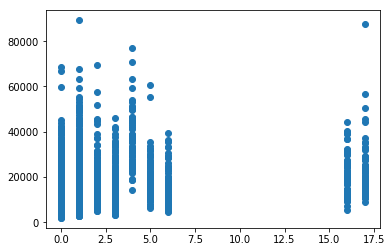

In [7]:
# plot some graphs, one example shown
plt.scatter(model_train_X['Away_Championships'], model_train_y)


In [8]:
# subsetting the training dataset
print model_train_X[0:3]
drop_cols = ['Season', 'Game_ID','Game_Date', 'Away_Team', 'Home_Team']

t_X = model_train_X.drop(drop_cols, axis=1) # should we do normalization?
o_X = model_output_X.drop(drop_cols, axis=1)


    Season   Game_ID   Game_Date Away_Team Home_Team  Year  Rivalry  Day_Code  \
0  2016-17  21600001  10/25/2016       NYK       CLE     0        0         1   
1  2016-17  21600003  10/25/2016       SAS       GSW     0        0         1   
2  2016-17  21600002  10/25/2016       UTA       POR     0        0         1   

   Holiday  First      ...       Home_Market_Size  Away_Market_Size  \
0        0      1      ...                 4053.0           19995.0   
1        0      1      ...                 6750.0            2193.0   
2        0      1      ...                 3010.0            2505.0   

   Home_Championships  Away_Championships  Home_Playoffs  Away_Playoffs  \
0                 1.0                 2.0            7.0            5.0   
1                 4.0                 5.0            5.0           16.0   
2                 1.0                 0.0            9.0            8.0   

   Home_Twitter  Away_Twitter  Home_Win_Pct  Away_Win_Pct  
0         1.138         1.393

In [9]:
# make train set of 1200
model_sub_X = t_X[0 : 1540]
model_sub_y = model_train_y[0 : 1540]

# make holdout/test set that we will use to evaluate our model
model_holdout_X = t_X[1540 :]
model_holdout_y = model_train_y[1540 :]


In [10]:
def mape(predict, actual):
    n = len(predict)
    sum_score = 0.0
    for i in xrange(n):
        sum_score += abs((predict[i] - actual[i]) / float(actual[i]))
    return (1 / float(n)) * sum_score

# define regression model builder
def reg_model(model, model_t_X, model_t_y, model_cv_X, model_cv_y):
    reg = model
    reg.fit(model_t_X, model_t_y)
    model_cv_pred = reg.predict(model_cv_X)
    return mape(model_cv_pred, model_cv_y)


In [32]:
# name models
linear = linear_model.LinearRegression(normalize=False) # linear regression
rf = RandomForestRegressor(max_depth=10, random_state=0,
                            criterion='mae', n_estimators=10) # random forest
dt = tree.DecisionTreeRegressor() # decision tree
nb = GaussianNB() # naive bayes
svr = SVR(C=1.0, epsilon=0.2) # support vector machine
mlp = MLPRegressor() # multi layer perceptron
ridge = Ridge(alpha=1.0) # ridge regression
neigh = KNeighborsRegressor(n_neighbors=3) # k nearest neighbors


In [33]:
# choose which model to use
MODEL_NAME = rf

par = [1]
for p in par:
    # print p, ":"
    # build k folds
    k = 10
    n = len(model_sub_X)
    mapes = []
    for i in xrange(k):
        model_cv_X = model_sub_X[i : i + n / k]
        model_cv_y = model_sub_y[i : i + n / k]
        model_t_X = model_sub_X[:i].append(model_sub_X[(i + n/k):])
        model_t_y = model_sub_y[:i] + model_sub_y[(i + n/k):]
        mapes.append(reg_model(MODEL_NAME,
                               model_t_X, model_t_y, model_cv_X, model_cv_y))
    print np.mean(mapes)
print model_t_X.shape, len(model_t_y), model_cv_X.shape, len(model_cv_y)

0.277888120074
(1386, 18) 1386 (154, 18) 154


In [34]:
print reg_model(MODEL_NAME, model_sub_X, model_sub_y, model_holdout_X, model_holdout_y)


0.503924767547


In [36]:
# predict final values for output (test) set 
final_model_train_X = t_X
final_model_test_X = o_X

FINAL_MODEL = rf

# train and predict
reg = FINAL_MODEL
reg.fit(final_model_train_X, model_train_y)
model_test_pred = reg.predict(final_model_test_X)

final_model_test_pred = []
# round output values
for total in model_test_pred:
    final_model_test_pred.append(round(total, 3))
    
print final_model_test_pred[0:3], len(final_model_test_pred)


[19428.6, 22434.45, 33244.1] 460


In [37]:
new_df = test_df.drop(['Total_Viewers'], axis=1)
new_df['Total_Viewers'] = final_model_test_pred

print new_df[0:3]
new_df.to_csv('test_set_Columbia.csv')


    Season   Game_ID   Game_Date Away_Team Home_Team  Total_Viewers
0  2016-17  21600010  10/26/2016       DEN       NOP       19428.60
1  2016-17  21600023  10/28/2016       HOU       DAL       22434.45
2  2016-17  21600027  10/29/2016       BOS       CHA       33244.10
